In [34]:
# Импорты

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

import joblib

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [35]:
# Загрузка датасета

df = pd.read_csv('spotify_songs.csv')

print(f'Размер датасета: {df.shape}')
print('\nПервые 5 строк датасета:')
df.head()

Размер датасета: (32833, 23)

Первые 5 строк датасета:


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [47]:
# Определение числовых и текстовых признаков

required_numeric_cols = ['danceability', 'energy', 'key', 'loudness', 'mode',
                         'speechiness', 'acousticness', 'instrumentalness',
                         'liveness', 'valence', 'tempo', 'duration_ms']

available_numeric_cols = [c for c in required_numeric_cols if c in df.columns]
if not available_numeric_cols:
    raise ValueError('Не найдено необходимых фич')
print(f'Фичи: {available_numeric_cols}')

text_cols = [c for c in ['track_name','track_artist','track_album_name','playlist_name','playlist_genre'] if c in df.columns]
print(f'Текстовые поля: {text_cols}')

Фичи: ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
Текстовые поля: ['track_name', 'track_artist', 'track_album_name', 'playlist_name', 'playlist_genre']


In [48]:
# Препроцессинг

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_raw = df[available_numeric_cols].copy()
X_imp = pd.DataFrame(imputer.fit_transform(X_raw), columns=available_numeric_cols, index=df.index)
X_scaled = pd.DataFrame(scaler.fit_transform(X_imp), columns=available_numeric_cols, index=df.index)

X_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,32833.0,1.385031e-16,1.000015,-4.513616,-0.633082,0.118211,0.731653,2.261810
energy,32833.0,4.031740e-16,1.000015,-3.860786,-0.650163,0.123714,0.781509,1.665940
key,32833.0,-8.330477e-17,1.000015,-1.488113,-0.934342,0.173200,1.003856,1.557627
loudness,32833.0,1.449955e-17,1.000015,-13.294279,-0.485713,0.185216,0.694186,2.675185
mode,32833.0,-6.248872e-17,1.000015,-1.141322,-1.141322,0.876177,0.876177,0.876177
speechiness,32833.0,-1.182687e-16,1.000015,-1.056809,-0.652121,-0.439907,0.246089,8.004256
acousticness,32833.0,4.371505e-17,1.000015,-0.798317,-0.729565,-0.432245,0.362731,3.727493
instrumentalness,32833.0,-7.871956e-17,1.000015,-0.377953,-0.377953,-0.377881,-0.356412,4.055060
liveness,32833.0,1.231650e-16,1.000015,-1.232390,-0.631671,-0.409398,0.374713,5.221943
valence,32833.0,1.579801e-16,1.000015,-2.189910,-0.770177,0.006172,0.782522,2.060710


In [49]:
# Удаление выбросов

iso = IsolationForest(contamination='auto', random_state=SEED)
iso.fit(X_scaled)
labels_if = iso.predict(X_scaled)
mask_inliers = labels_if == 1

df_train = df[mask_inliers].reset_index(drop=True)
X_train = X_scaled[mask_inliers].reset_index(drop=True)
print(f'Доля выбросов: {round(1 - mask_inliers.mean(), 3)}')
print(f'Доля оставшихся: {round(mask_inliers.mean(), 3)}')
print(f'Новый размер датасета: {X_train.shape}')

Доля выбросов: 0.181
Доля оставшихся: 0.819
Новый размер датасета: (26901, 12)


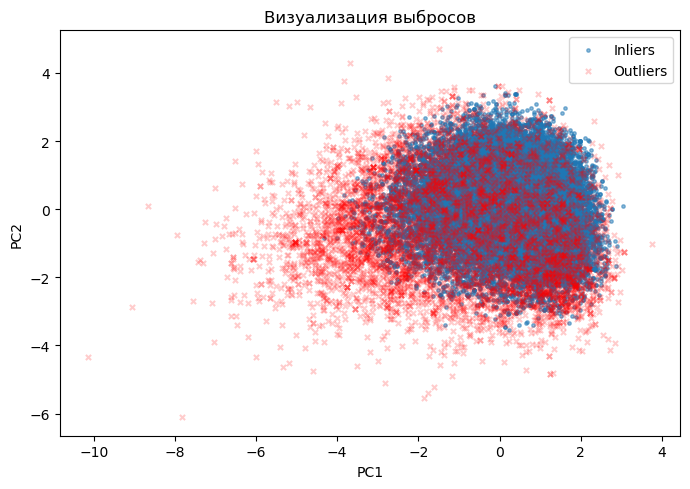

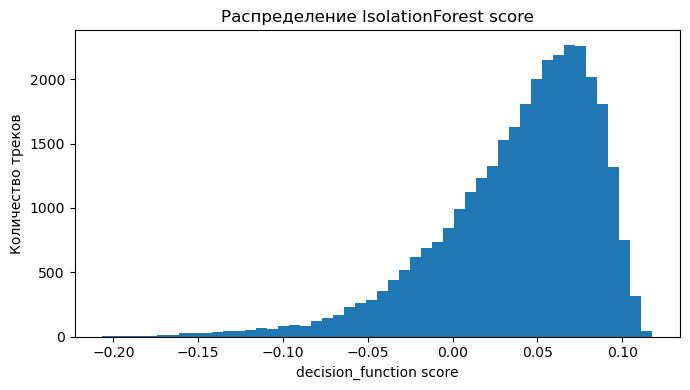

In [50]:
# Визуализации для выбросов

pca = PCA(n_components=2, random_state=SEED)
X_emb = pca.fit_transform(X_scaled)

inliers = mask_inliers
outliers = ~mask_inliers

plt.figure(figsize=(7,5))
plt.scatter(X_emb[inliers, 0], X_emb[inliers, 1],
            s=6, alpha=0.5, label='Inliers')
plt.scatter(X_emb[outliers, 0], X_emb[outliers, 1],
            s=14, alpha=0.2, marker='x', color='red', label='Outliers')
plt.title('Визуализация выбросов')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.show()

if_scores = iso.decision_function(X_scaled)
plt.figure(figsize=(7,4))
plt.hist(if_scores, bins=50)
plt.title('Распределение IsolationForest score')
plt.xlabel('decision_function score')
plt.ylabel('Количество треков')
plt.tight_layout()
plt.show()

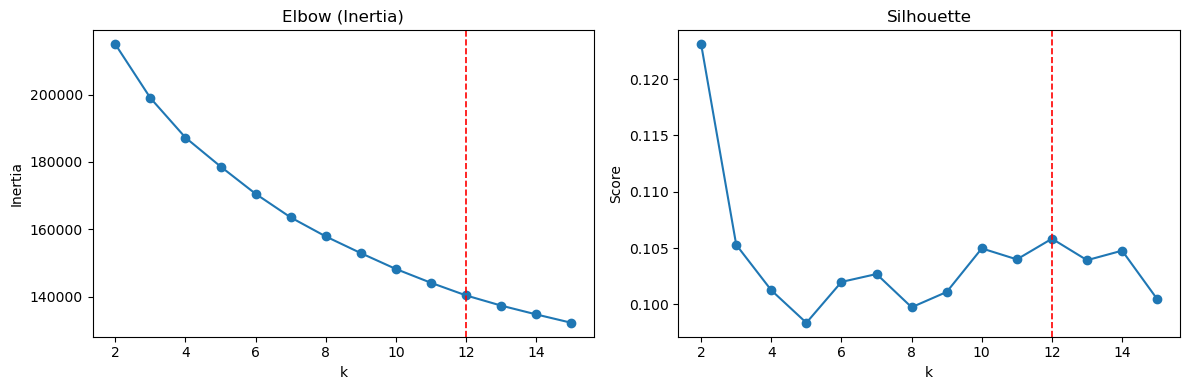

Выбрано k = 12


In [ ]:
# Поиск оптимального количества кластеров

def search_k(X, k_min=2, k_max=15, random_state=SEED):
    inertias, silhouettes = [], []
    ks = list(range(k_min, k_max + 1))
    for k in ks:
        km = KMeans(n_clusters=k, n_init=20, random_state=random_state)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        try:
            sil = silhouette_score(X, labels)
        except Exception:
            sil = np.nan
        silhouettes.append(sil)
    return ks, inertias, silhouettes

ks, inertias, silhouettes = search_k(X_train, k_min=2, k_max=15)

valid = ~pd.isna(silhouettes)
if valid.any():
    ks_valid  = np.array(ks)[valid]
    sil_valid = np.array(silhouettes)[valid]
    mask = ks_valid >= 3
    best_k = ks_valid[mask][np.argmax(sil_valid[mask])] if mask.any() else ks_valid[np.argmax(sil_valid)]
else:
    rel_drop = np.diff(inertias) / np.maximum(inertias[:-1], 1e-9)
    elbow_idx = np.where(np.abs(rel_drop) < 0.1)[0]
    best_k = ks[elbow_idx[0] + 1] if len(elbow_idx) else 8

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(ks, inertias, 'o-')
axes[0].set_title('Elbow (Inertia)')
axes[0].set_xlabel('k'); axes[0].set_ylabel('Inertia')

axes[1].plot(ks, silhouettes, 'o-')
axes[1].set_title('Silhouette')
axes[1].set_xlabel('k'); axes[1].set_ylabel('Score')

for ax in axes:
    ax.axvline(best_k, linestyle="--", color="red", linewidth=1.2)

plt.tight_layout()
plt.show()

print(f"Выбрано k = {best_k}")

In [52]:
# Обучение модели

kmeans = KMeans(n_clusters=int(best_k), n_init=20, random_state=SEED)
kmeans.fit(X_train)
labels_all = kmeans.predict(X_scaled)
df = df.copy()
df['cluster'] = labels_all
df['cluster'].value_counts().sort_index()

cluster
0     3372
1     1990
2     3049
3     1767
4     2767
5     3023
6     2143
7     2997
8     3310
9     2347
10    3054
11    3014
Name: count, dtype: int64

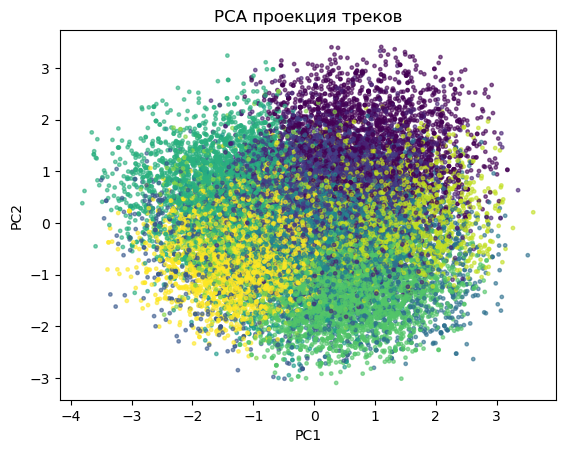

,PC1,PC2
danceability,0.520216,-0.232595
acousticness,0.308063,0.154896
valence,0.288243,-0.324337
speechiness,0.150028,-0.191340
key,0.076509,-0.488776
duration_ms,0.007188,0.128352
instrumentalness,-0.072285,-0.009072
mode,-0.108339,0.557119
liveness,-0.227110,-0.115347
loudness,-0.323338,-0.286737


In [ ]:
# PCA визуализация кластеров

pca = PCA(n_components=2, random_state=SEED)
X_emb = pca.fit_transform(X_train)

plt.figure()
plt.scatter(X_emb[:,0], X_emb[:,1], c=df.loc[mask_inliers, 'cluster'].values, s=6, alpha=0.6)
plt.title('PCA проекция треков')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC1', 'PC2'], 
                        index=available_numeric_cols)
loadings.sort_values('PC1', ascending=False)

In [54]:
# Сохранение файлов

joblib.dump(imputer, 'imputer.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(kmeans, 'kmeans_model.joblib')

df.to_csv('spotify_with_clusters.csv', index=False)

In [57]:
# Рекомендательная система

def _match_tracks(df: pd.DataFrame, track_query: str, artist_query: str=None, top_k: int=5):
    mask = pd.Series([True]*len(df))
    if 'track_name' in df.columns and track_query:
        mask &= df['track_name'].astype(str).str.contains(track_query, case=False, na=False)
    if artist_query and 'track_artist' in df.columns:
        mask &= df['track_artist'].astype(str).str.contains(artist_query, case=False, na=False)
    candidates = df[mask]
    def score_row(r):
        s = 0
        tn = str(r.get('track_name','')).lower()
        ar = str(r.get('track_artist','')).lower()
        if track_query and track_query.lower() in tn: s += 2
        if artist_query and artist_query.lower() in ar: s += 2
        return s
    candidates = candidates.copy()
    if not candidates.empty:
        candidates['__score'] = candidates.apply(score_row, axis=1)
        candidates = candidates.sort_values(['__score'], ascending=False)
    return candidates.head(top_k)

def recommend_by_track_name(track_query: str, artist_query: str=None, n_recs: int=10, random_state: int=42):
    rng = np.random.default_rng(random_state)
    candidates = _match_tracks(df, track_query, artist_query, top_k=5)
    if candidates.empty:
        print('Трек в датасете не найден, необходимо уточнить')
        return pd.DataFrame()

    picked = candidates.iloc[0]
    x = picked[available_numeric_cols].values.reshape(1, -1)
    imp = joblib.load('imputer.joblib')
    sclr = joblib.load('scaler.joblib')
    x_proc = sclr.transform(imp.transform(x))

    km = joblib.load('kmeans_model.joblib')
    cluster_id = km.predict(x_proc)[0]

    same_cluster = df[df['cluster'] == cluster_id]
    if 'track_name' in df.columns:
        same_cluster = same_cluster[~((same_cluster['track_name'] == picked.get('track_name')) &
                                      (same_cluster.get('track_artist','') == picked.get('track_artist','')))]

    if len(same_cluster) <= n_recs:
        recs = same_cluster.sample(n=len(same_cluster), random_state=random_state)
    else:
        idx = rng.choice(same_cluster.index.values, size=n_recs, replace=False)
        recs = same_cluster.loc[idx]

    cols_to_show = [c for c in ['track_name','track_artist','track_album_name','playlist_name','playlist_genre'] if c in same_cluster.columns]
    cols_to_show = cols_to_show + ['cluster']
    print(f"Выбран трек: {picked.get('track_name','?')} — {picked.get('track_artist','?')} | Кластер = {cluster_id}")
    return recs[cols_to_show].reset_index(drop=True)


In [58]:
recs = recommend_by_track_name(track_query='Lithium', artist_query='Nirvana', n_recs=10)
recs

Выбран трек: Lithium — Nirvana | Кластер = 5


c:\Users\aloeseasnn\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\aloeseasnn\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\aloeseasnn\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


,track_name,track_artist,track_album_name,playlist_name,playlist_genre,cluster
0,Meant to Be (feat. Florida Georgia Line),Bebe Rexha,Expectations,Intro to Post-Teen Pop,pop,5
1,gone girl,iann dior,Industry Plant,Pop Hits 2020,r&b,5
2,Made In The USA,Demi Lovato,Demi,🤩🤪Post Teen Pop🤪🤩,pop,5
3,Señorita,Reykon,El Lider 1,REGGAETON VIEJO,latin,5
4,Hang on to Yourself,Palaye Royale,Hang on to Yourself,Modern Indie Rock // Alternative Rock / Garage...,rock,5
5,Television,The Academic,Tales from the Backseat,permanent wave,rock,5
6,Bailando - English Version,Enrique Iglesias,SEX AND LOVE (Deluxe Edition),Latest Latin American Hits 2020,latin,5
7,Lemontree,Julian Daniel,Lemontree,a taste of the mainstream,pop,5
8,Loudspeaker,MUNA,Loudspeaker,Indie Poptimism!,pop,5
9,Addicted,Amy Winehouse,Back To Black,Soul Coffee (The Best Neo-Soul Mixtape ever),r&b,5
